In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import cv2 as cv2
import numpy as np
import os
import torch.optim as optim
import torch.nn.functional as F

In [2]:
psf_in_pixels = np.load('image.npy')
lattice_grid = np.load('lattice.npy')

psf_in_pixels = psf_in_pixels / psf_in_pixels.sum()

In [3]:
radio = 20 / 2
center_x, center_y = 33, 33 
inicio_x, inicio_y = int(center_x - radio), int(center_y - radio)
fin_x, fin_y = int(center_x + radio), int(center_y + radio)

psf_recortada = psf_in_pixels[inicio_y:fin_y, inicio_x:fin_x]
psf_in_pixels = psf_recortada / psf_recortada.sum()

In [4]:
class LatticeDataset(Dataset):
    def __init__(self, image_dir, lattice_points, crop_size=(20,20), image_size=(200, 200)):
        """
        Args:
            image_dir (string): Directory with all the images.
            lattice_points (list of tuples): List of (x, y) tuples indicating the lattice grid points.
            crop_size (tuple): Desired size of the cropped images in pixels as (width, height).
            image_size (tuple): Final image size to crop from (width, height).
        """
        self.image_dir = image_dir
        self.lattice_points = lattice_points
        self.crop_size = crop_size
        self.image_size = image_size
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]


        self.num_crops_x = image_size[0] // crop_size[0]
        self.num_crops_y = image_size[1] // crop_size[1]
        self.total_crops = self.num_crops_x * self.num_crops_y * len(self.image_files)

    def __len__(self):
        return self.total_crops

    def __getitem__(self, idx):
        image_idx = idx // (self.num_crops_x * self.num_crops_y)
        crop_idx = idx % (self.num_crops_x * self.num_crops_y)
        row_idx, col_idx = divmod(crop_idx, self.num_crops_x)

        img_path = os.path.join(self.image_dir, self.image_files[image_idx])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Failed to load image: {img_path}")

        max_img = np.max(img)
        img = img/max_img

        img_center_x, img_center_y = img.shape[1] // 2, img.shape[0] // 2
        img_start_x, img_start_y = img_center_x - (self.image_size[0] // 2), img_center_y - (self.image_size[1] // 2)
        img_end_x, img_end_y = img_start_x + self.image_size[0], img_start_y + self.image_size[1]
        cropped_img = img[img_start_y:img_end_y, img_start_x:img_end_x]


        x_start = col_idx * self.crop_size[0]
        y_start = row_idx * self.crop_size[1]
        x_end = x_start + self.crop_size[0]
        y_end = y_start + self.crop_size[1]

        final_crop = cropped_img[y_start:y_end, x_start:x_end]

        max_pixel_value = np.max(final_crop)
        normalized_img_1 = (final_crop / max_pixel_value) * np.max(psf_in_pixels)
        max_pixel_value_psf = np.max(normalized_img_1)
        normalized_img = normalized_img_1/max_pixel_value_psf
        
        normalized_img = 2*final_crop-1

        lattice_positions_in_crop = [
            (x - x_start, y - y_start) for x, y in self.lattice_points
            if x_start <= x < x_end and y_start <= y < y_end
        ]

        normalized_img = torch.tensor(normalized_img, dtype=torch.float32).unsqueeze(0)
        lattice_positions = torch.tensor(lattice_positions_in_crop, dtype=torch.float32)
        return normalized_img, lattice_positions

In [6]:
dataset_train = LatticeDataset(image_dir=r"data\train_images",
                          lattice_points=lattice_grid)

data_loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True)


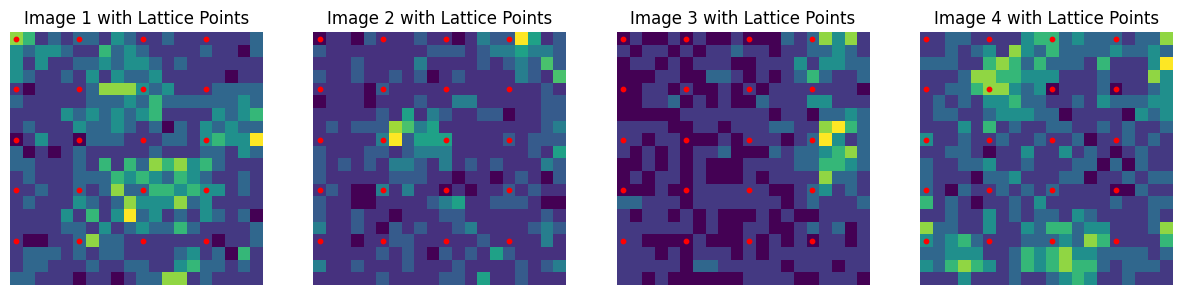

In [7]:
images, lattice_positions = next(iter(data_loader_train))
images_np = images.numpy()
lattice_positions_np = lattice_positions.numpy()
num_images_to_display = min(len(images_np), 4)

fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 15))

for i in range(num_images_to_display):
    ax = axes[i]
    ax.imshow(images_np[i].squeeze())
    lattice_points = lattice_positions_np[i]
    ax.scatter(lattice_points[:, 0], lattice_points[:, 1], c='red', s=10) 
    ax.set_title(f'Image {i+1} with Lattice Points')
    ax.axis('off')
plt.show()


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomAutoencoder(nn.Module):
    def __init__(self):
        super(CustomAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Agrega max pooling para reducción dimensional
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 10, kernel_size=3, stride=1, padding=1),  # Menos canales para un bottleneck más compacto
            nn.Tanh()
        )
        self.unbottleneck = nn.Sequential(
            nn.ConvTranspose2d(10, 128, kernel_size=3, stride=1, padding=1)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # Reemplaza transposed conv con upsampling para simplicidad
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 1, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        bottleneck = self.bottleneck(x)
        x = self.unbottleneck(bottleneck)
        decoded = self.decoder(x)
        return decoded, bottleneck


In [10]:
class CompositeLoss(nn.Module):
    def __init__(self, reconstruction_weight=1.0, bottleneck_weight=0.1):
        super(CompositeLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss()
        self.bottleneck_weight = bottleneck_weight
        self.reconstruction_weight = reconstruction_weight

    def forward(self, inputs, decoded, bottleneck):
        reconstruction_loss = self.reconstruction_loss(decoded, inputs)
        targets = self.estimate_bottleneck_targets(bottleneck)
        targets = targets.expand_as(bottleneck)
        regularization_loss = F.binary_cross_entropy_with_logits(bottleneck, targets)

        total_loss = (self.reconstruction_weight * reconstruction_loss +
                      self.bottleneck_weight * regularization_loss)
        return total_loss

    def estimate_bottleneck_targets(self, bottleneck):

        return torch.sigmoid(torch.mean(bottleneck, dim=[2, 3], keepdim=True))


In [12]:
# Ejemplo de uso
model = CustomAutoencoder()
criterion = CompositeLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

x = torch.randn((1, 1, 60, 60))
decoded, bottleneck = model(x)

print(decoded.shape)
print(bottleneck.shape)
print("Rango de valores en bottleneck:", bottleneck.min().item(), "a", bottleneck.max().item())

torch.Size([1, 1, 60, 60])
torch.Size([1, 10, 15, 15])
Rango de valores en bottleneck: -0.2604411244392395 a 0.1937103122472763


In [13]:
def visualize_reconstructions(model, data_loader, num_images=5, device='cpu'):
    model.eval()
    images, _ = next(iter(data_loader))
    images = images.to(device)
    with torch.no_grad():
        reconstructions, bottleneck = model(images)

    images = images[:num_images].cpu()
    reconstructions = reconstructions[:num_images].cpu() 
    bottleneck = bottleneck[:num_images].cpu()

    num_channels = bottleneck.size(1)


    fig, axes = plt.subplots(num_images, num_channels + 2, figsize=(2 * (num_channels + 2), 2 * num_images)) 

    for i in range(num_images):
        axes[i, 0].imshow(images[i].squeeze().numpy(), cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(reconstructions[i].squeeze().numpy(), cmap='gray')
        axes[i, 1].set_title('Reconstruction')
        axes[i, 1].axis('off')

        for j in range(num_channels):
            avg_activations = bottleneck[i, j].cpu().numpy()
            axes[i, j + 2].imshow(avg_activations, cmap='gray')
            axes[i, j + 2].set_title(f'Bottleneck {j+1}')
            axes[i, j + 2].axis('off')
            if j == 9:
                print(avg_activations)

            

    plt.show()

In [ ]:
learning_rate = 0.001
patience = 10

model = CustomAutoencoder()
criterion = CompositeLoss()
train_epochs = []

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, factor=0.5)

def train_with_visualization(model, criterion, optimizer, scheduler, data_loader_train, epochs=50, device='cpu'):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, atom_position in data_loader_train:
            inputs = inputs.to(device)
            atom_position = atom_position.to(device)

            optimizer.zero_grad()
            decoded, bottleneck = model(inputs)
            loss = criterion(inputs, decoded, bottleneck)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(data_loader_train.dataset)
        visualize_reconstructions(model, data_loader_train)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.11f}")
        train_epochs.append(epoch_loss)

        scheduler.step(epoch_loss)
    torch.save(model.state_dict(), "model_canals_20.pth")

train_with_visualization(model, criterion, optimizer, scheduler, data_loader_train, epochs=5, device='cpu')

In [9]:
model = CustomAutoencoder()
model.load_state_dict(torch.load(r"model_canals_20.pth"))
model.eval()

CustomAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (bottleneck): Sequential(
    (0): Conv2d(128, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
  )
  (unbottleneck): Sequential(
    (0): ConvTranspose2d(10, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4):